In [1]:
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement
from astropy.cosmology import Planck18 as cosmo
from astropy.cosmology import z_at_value
import astropy.units as u
from astropy import constants as cte

In [2]:
# --- Constantes ---
c = 299792458 # m/s
c_ast = 299792.458 # km/s
G = 6.6743e-11 # m^3 / (kg s^2)
G_ast = 4.517103049894964e-30 # pc^3 / (s^2 solMass)

In [3]:
# Parámetros del cúmulo
M_DM_cluster = 1e5
M_PBH = 10
N_PBH_i_Msun = M_DM_cluster / (2 * M_PBH)
N_PBH_j_Msun = M_DM_cluster / (2 * M_PBH)
N_PBH_total = 2 * N_PBH_i_Msun
R_cluster = 1.096132

# Radios de evaluación
r_values_pc = np.linspace(0.1, R_cluster, 10)

In [4]:
print("BOUNDARY CONDITIONS TO CLUSTER")
print(f"Number of PBHs into cluster: {N_PBH_total:.0f} of {M_PBH} Solar Masses")
print(f"Cluster radius (parsecs): {R_cluster:.1f}")

BOUNDARY CONDITIONS TO CLUSTER
Number of PBHs into cluster: 10000 of 10 Solar Masses
Cluster radius (parsecs): 1.1


radius (pc)    n_pbh(r)
0.10           1776
0.21           1656
0.32           1475
0.43           1263
0.54           1048
0.65           848 
0.76           673 
0.87           529 
0.99           412 
1.10           320 


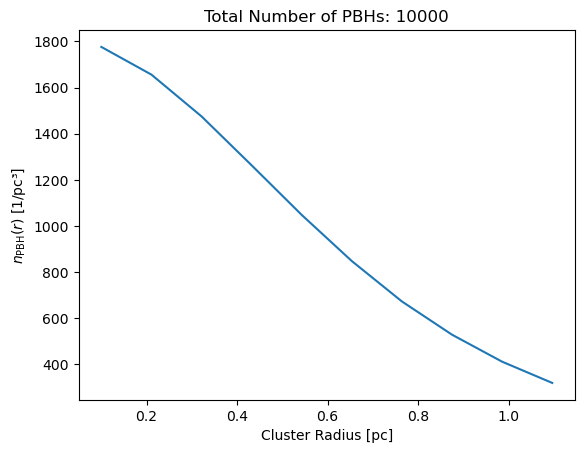

In [5]:
# --- Funciones físicas ---
def rho(r):
    factor = (3 * M_DM_cluster) / (4 * np.pi * R_cluster**3)
    shape = 1 + (r / R_cluster)**2
    return factor * shape**(-2.5)

def n_pbh(r, M_pbh):
    return (rho(r) / M_pbh)

n_PBH_r = np.array([
    round(n_pbh(r, M_PBH))
    for r in r_values_pc
])
n_total = np.sum(n_PBH_r)

# Imprimir
print(f"{'radius (pc)':<15}{'n_pbh(r)'}")
print("=" * 24)
for r, n in zip(r_values_pc, n_PBH_r):
    print(f"{r:<15.2f}{n:<4}")

plt.plot(r_values_pc, n_PBH_r)
plt.xlabel("Cluster Radius [pc]")
plt.ylabel("$n_\\mathrm{PBH}(r)$ [1/pc³]")
plt.title(f"Total Number of PBHs: {int(n_total)}")
plt.show()

In [6]:
def phi(r, M_cluster):
    phi_r = ((G_ast * M_cluster / R_cluster) * (1 + (r / R_cluster)**2)**(-0.5))
    return phi_r * 9.5214e26 # km^2/s^2

def f_E(E, N_pbh, M_cluster):
    E = E / 9.5214e26
    num = 24 * np.sqrt(2) * N_pbh * R_cluster**2 * E**(3.5)
    denom = 7 * np.pi**3 * G_ast**5 * M_cluster**5
    return (num / denom) * 3.404e-41

def integrand(E_val, r, N_pbh, M_cluster):
    phi_val = phi(r, M_cluster)
    delta_E = 2 * (phi_val - E_val)
    return f_E(E_val, N_pbh, M_cluster) * delta_E**1.5

def mean_square_velocity(r, M_cluster, N_pbh, M_pbh):
    n_r = (rho(r) / M_pbh)
    if n_r == 0:
        return 0.0
    phi_r = phi(r, M_cluster)
    integral, _ = spi.quad(integrand, 0, phi_r, args=(r, N_pbh, M_cluster))
    return np.sqrt((4 * np.pi / n_r) * integral)

In [7]:
v_mean_values = np.array([
    mean_square_velocity(r, M_DM_cluster, N_PBH_total, M_PBH)
    for r in r_values_pc
])

for r, v in zip(r_values_pc, v_mean_values):
    print(f"r = {r:.2f},  v_rms = {v:.3f}")

v_0 = np.mean(v_mean_values) #(u.km / u.s)

print(f"\n v0 = {v_0:.3f}")

r = 0.10,  v_rms = 13.978
r = 0.21,  v_rms = 13.881
r = 0.32,  v_rms = 13.721
r = 0.43,  v_rms = 13.511
r = 0.54,  v_rms = 13.260
r = 0.65,  v_rms = 12.982
r = 0.76,  v_rms = 12.687
r = 0.87,  v_rms = 12.384
r = 0.99,  v_rms = 12.079
r = 1.10,  v_rms = 11.779

 v0 = 13.026


In [104]:
km_to_pc = 1 / 3.085677581e13 
# --- Secciones eficaces ---
def sigma_BPBH(m1, m2, v_i, v_j):
    G_astro = G_ast
    c_astro = c_ast
    prefactor = (340 * np.pi / 3)**(2/7)
    num = np.pi * prefactor * G_astro**2 * (m1 + m2)**(10/7) * (m1 * m2)**(2/7)
    if v_i == v_j:
        denom = c_astro**(10/7) * np.abs(v_0)**(18/7)
    else:
        denom = c_astro**(10/7) * (np.abs(v_i - v_j))**(18/7)
    return (num / denom) * (3.085677581e13)**4

def sigma_CHES(m1, m2, v_i, v_j):
    G_astro = G_ast
    e = 1.00001
    if v_i == v_j:
        b = (G_astro * (m1 + m2) / v_i**2)
    else:
        b = (G_astro * (m1 + m2) / (np.abs(v_i - v_j))**2)
    b = b / (3.085677581e13**-2)
    return np.pi * b**2 * (e**2 - 1)

In [105]:
# --- Integral I ---
def integrand_I(r_i, r_j, N_pbh_i, M_pbh_i, N_pbh_j, M_pbh_j, M_cluster):
    if M_pbh_i == M_pbh_j:
        n_i = n_pbh(r_i, M_pbh_i) / 2
        n_j = n_i
        v_i = mean_square_velocity(r_i, M_cluster, 2*N_pbh_i, M_pbh_i) * km_to_pc
        v_j = v_i
    else:
        n_i = n_pbh(r_i, M_pbh_i)
        v_i = mean_square_velocity(r_i, M_cluster, N_pbh_i, M_pbh_i) * km_to_pc
        v_j = mean_square_velocity(r_j, M_cluster, N_pbh_j, M_pbh_j) * km_to_pc
    term = (v_j + v_i)**(3/7) - abs(v_j - v_i)**(3/7)
    return r_i**2 * (n_i / v_i) * term

def I_rj(r_j, N_pbh_i, M_pbh_i, N_pbh_j, M_pbh_j, M_cluster):
    args = (r_j, N_pbh_i, M_pbh_i, N_pbh_j, M_pbh_j, M_cluster)
    integral, _ = spi.quad(integrand_I, 0.1 * R_cluster, R_cluster, args=args)
    return integral

I_values = np.array([I_rj(r_j, N_PBH_i_Msun, M_PBH, N_PBH_j_Msun, M_PBH, M_DM_cluster) for r_j in r_values_pc])
coeffs = np.polyfit(r_values_pc, I_values, 3)

In [106]:
# --- Gamma ---
def Gamma_rj(r_j, N_pbh_j, M_pbh_j, N_pbh_i, M_pbh_i, M_cluster):
    n_j = n_pbh(r_j, M_pbh_j)
    v_j = mean_square_velocity(r_j, M_cluster, N_pbh_j, M_pbh_j) * km_to_pc
    v_i = mean_square_velocity(r_j, M_cluster, N_pbh_i, M_pbh_i) * km_to_pc
    sigma_B = sigma_BPBH(M_pbh_i, M_pbh_j, v_i/km_to_pc, v_j/km_to_pc)
    sigma_C = sigma_CHES(M_pbh_i, M_pbh_j, v_i/km_to_pc, v_j/km_to_pc)
    if v_j == 0 or n_j == 0:
        return 0, 0
    I_val = np.polyval(coeffs, r_j)
    if v_i == v_j:
        v_mean_values = np.array([
            mean_square_velocity(r, M_DM_cluster, N_pbh_i*2, M_pbh_i)
            for r in r_values_pc]
        )
        v_0 = np.mean(v_mean_values) * km_to_pc
        gamma_BBH = (v_0)**(18/7) * (14 * np.pi / 3) * sigma_B * (n_j / v_j) * I_val
        gamma_CHE = (v_0)**(18/7) * (14 * np.pi / 3) * sigma_C * (n_j / v_j) * I_val
    else:
        gamma_BBH = (np.abs(v_i - v_j))**(18/7) * (14 * np.pi / 3) * sigma_B * (n_j / v_j) * I_val
        gamma_CHE = (np.abs(v_i - v_j))**(18/7) * (14 * np.pi / 3) * sigma_C * (n_j / v_j) * I_val
    return gamma_BBH, gamma_CHE

r = 0.100 pc | Gamma_BBH = 4.730e-18 [1/s] | Gamma_CHE = 1.348e-16 [1/s]
r = 0.211 pc | Gamma_BBH = 4.441e-18 [1/s] | Gamma_CHE = 1.302e-16 [1/s]
r = 0.321 pc | Gamma_BBH = 4.003e-18 [1/s] | Gamma_CHE = 1.229e-16 [1/s]
r = 0.432 pc | Gamma_BBH = 3.482e-18 [1/s] | Gamma_CHE = 1.138e-16 [1/s]
r = 0.543 pc | Gamma_BBH = 2.942e-18 [1/s] | Gamma_CHE = 1.036e-16 [1/s]
r = 0.653 pc | Gamma_BBH = 2.431e-18 [1/s] | Gamma_CHE = 9.317e-17 [1/s]
r = 0.764 pc | Gamma_BBH = 1.977e-18 [1/s] | Gamma_CHE = 8.305e-17 [1/s]
r = 0.875 pc | Gamma_BBH = 1.590e-18 [1/s] | Gamma_CHE = 7.359e-17 [1/s]
r = 0.985 pc | Gamma_BBH = 1.271e-18 [1/s] | Gamma_CHE = 6.498e-17 [1/s]
r = 1.096 pc | Gamma_BBH = 1.013e-18 [1/s] | Gamma_CHE = 5.729e-17 [1/s]


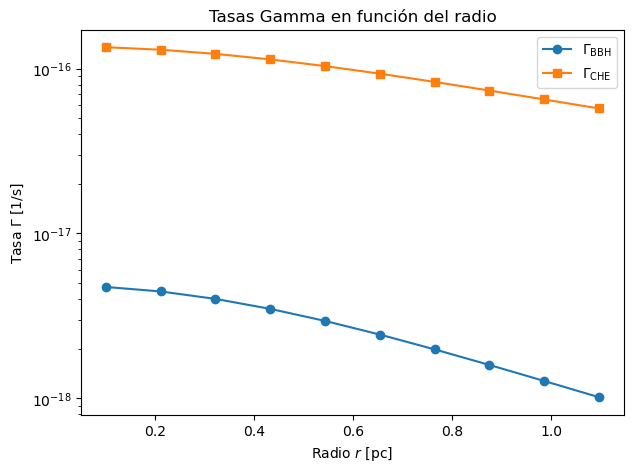

In [107]:
Gamma_BBH_values = np.array([
    Gamma_rj(r_j, N_PBH_j_Msun, M_PBH, N_PBH_i_Msun, M_PBH, M_DM_cluster)[0]
    for r_j in r_values_pc
])

Gamma_CHES_values = np.array([
    Gamma_rj(r_j, N_PBH_j_Msun, M_PBH, N_PBH_i_Msun, M_PBH, M_DM_cluster)[1]
    for r_j in r_values_pc
])

for r, g_bbh, g_che in zip(r_values_pc, Gamma_BBH_values, Gamma_CHES_values):
    print(f"r = {r:.3f} pc | Gamma_BBH = {g_bbh:.3e} [1/s] | Gamma_CHE = {g_che:.3e} [1/s]")

# Graficar
plt.figure(figsize=(7,5))
plt.plot(r_values_pc, Gamma_BBH_values, 'o-', label=r'$\Gamma_{\mathrm{BBH}}$')
plt.plot(r_values_pc, Gamma_CHES_values, 's-', label=r'$\Gamma_{\mathrm{CHE}}$')
plt.xlabel("Radio $r$ [pc]")
plt.ylabel(r"Tasa $\Gamma$ [1/s]")
plt.yscale('log')
plt.title("Tasas Gamma en función del radio")
plt.legend()
plt.show()

In [108]:
# Edad del universo
age_universe_Gyr = 13.786885302009708  # Gyr
age_universe_yr = age_universe_Gyr * 1e9  # yr

# Conversión de tasas a unidades por año
seconds_per_year = 3.15576e7  # s/yr
Gamma_BBH_values_yr = Gamma_BBH_values * seconds_per_year
Gamma_CHES_values_yr = Gamma_CHES_values * seconds_per_year

time_first_merger_yr =  1/Gamma_BBH_values_yr
time_first_merger_Gyr = time_first_merger_yr / 1e9

time_first_ches_yr = 1/Gamma_CHES_values_yr
time_first_ches_Gyr = time_first_ches_yr / 1e9

In [109]:
print(f"{'Gamma_BPBH(yr^-1)':<20}{'Time to 1st merger (Gyr)':<28}{'Gamma_CHES(yr^-1)':<20}{'Time to 1st CHEs (yr)':<28}")
print("=" * 90)
for i in range(len(r_values_pc)):
    print(f"{Gamma_BBH_values_yr[i]:<20.3e}{time_first_merger_Gyr[i]:<28.3e}{Gamma_CHES_values_yr[i]:<20.3e}{time_first_ches_yr[i]:.3e}")


time_z_20 = cosmo.age(20).to(u.yr).value
delta_t_merger = np.min(time_first_merger_yr)
print("\nTime necessary to all PBHs\nfrom first radius coallesences:", delta_t_merger/1e9, "Gyr")

delta_t_CHEs = np.min(time_first_ches_yr)# + time_z_20
print("\nTime necessary to maximum probability\nto produces CHEs in the first shell: ",delta_t_CHEs,"years")

Gamma_BPBH(yr^-1)   Time to 1st merger (Gyr)    Gamma_CHES(yr^-1)   Time to 1st CHEs (yr)       
1.493e-10           6.699e+00                   4.256e-09           2.350e+08
1.402e-10           7.135e+00                   4.109e-09           2.434e+08
1.263e-10           7.916e+00                   3.879e-09           2.578e+08
1.099e-10           9.100e+00                   3.590e-09           2.786e+08
9.286e-11           1.077e+01                   3.269e-09           3.059e+08
7.673e-11           1.303e+01                   2.940e-09           3.401e+08
6.238e-11           1.603e+01                   2.621e-09           3.815e+08
5.018e-11           1.993e+01                   2.322e-09           4.306e+08
4.011e-11           2.493e+01                   2.051e-09           4.877e+08
3.197e-11           3.128e+01                   1.808e-09           5.531e+08

Time necessary to all PBHs
from first radius coallesences: 6.699484879356586 Gyr

Time necessary to maximum probability
to

In [110]:
# --- Constantes ---
G_SI = 6.67430e-11             # m³ / (kg·s²)
c_SI = 2.99792458e8            # m/s
Msun_kg = 1.98847e30           # kg
pc_m = 3.085677581e16          # m
AU_m = 1.495978707e11          # m
erg_in_joule = 1e-7            # 1 erg = 1e-7 J
AU_pc = AU_m / pc_m            # 1 AU in parsecs
seconds_per_year = 3.15576e7   # s/yr

In [111]:
def R_Swarzschild(m):
    return (2 * G_SI * m * Msun_kg) / c_SI**2 / pc_m

# --- Energía radiada BBH ---
def E_rad_GW(m1, m2):
    # --- Parámetros de separación inicial y final ---
    if m1<m2:
        a0 = (2 * G_SI * m2 * Msun_kg) / c_SI**2 / pc_m   # pc
    if m2<m1:
        a0 = (2 * G_SI * m1 * Msun_kg) / c_SI**2 / pc_m   # pc
    if m1==m2:
        a0 = (2 * G_SI * m1 * Msun_kg) / c_SI**2 / pc_m   # pc
    a1 = 0.1 * AU_pc  # pc
    m1_kg = m1 * Msun_kg
    m2_kg = m2 * Msun_kg

    def integrand(a_pc):
        a_m = a_pc * pc_m
        return (G_SI * m1_kg * m2_kg) / (2 * a_m**2) * pc_m  # J

    integral, _ = spi.quad(integrand, a0, a1)
    return integral / erg_in_joule  # erg

# --- Masa final tras fusión BBH ---
def final_mass_GW(m1, m2):
    E_rad = E_rad_GW(m1, m2) * erg_in_joule  # J
    m_total = (m1 + m2) * Msun_kg
    m_final = m_total - E_rad / c_SI**2
    return m_final / Msun_kg  # M_sun

# --- Radio mínimo para CHES (en parsecs) ---
def r_min_CHES(m1, m2, K=0.00001):
    m1_kg = m1 * Msun_kg
    m2_kg = m2 * Msun_kg
    R_sch = lambda m: 2 * G_SI * m / c_SI**2  # m
    #return K * (R_sch(m1_kg) + R_sch(m2_kg)) / pc_m  # pc
    return (G_SI * (m1_kg + m2_kg) / v_0**2) * K / pc_m

# --- Energía radiada CHES ---
def E_rad_CHES(m1, m2, e=1.00001, K=0.00001):
    m1_kg = m1 * Msun_kg
    m2_kg = m2 * Msun_kg
    M = m1_kg + m2_kg
    r_min_m = r_min_CHES(m1, m2, K) * pc_m  # m

    # f(e) factor (Eq. 18)
    term1 = 24 * np.arccos(-1 / e) * (1 + (73/24)*e**2 + (37/96)*e**4)
    term2 = np.sqrt(e**2 - 1) * (301/6 + (673/12)*e**2)
    f_e = (1 / (1 + e)**(7/2)) * (term1 + term2)

    E_rad = (8/15) * G_SI**(3.5) * np.sqrt(M) * m1_kg**2 * m2_kg**2 / (c_SI**5 * r_min_m**(3.5)) * f_e
    return E_rad / erg_in_joule  # erg

In [112]:
# --- Evaluación de energías y masa final ---
E_BBH_event = E_rad_GW(M_PBH, M_PBH)             # erg
E_CHES_event = E_rad_CHES(M_PBH, M_PBH)                  # erg
final_masses = final_mass_GW(M_PBH, M_PBH)       # M_sun

In [113]:
time_values_interval_0 = np.linspace(1e3, delta_t_CHEs, 300) #Years
time_values_interval_0 = np.insert(time_values_interval_0, 0, 0.0)
time_values_interval_1 = np.linspace(delta_t_CHEs, 3.3e+09, 500) #Years
time_values_interval = np.concatenate((time_values_interval_0, time_values_interval_1[1:]))

t_yr=[]
redshift_evaluated_0 = []
for t in time_values_interval:
    t_yr.append(t + time_z_20)
    t_gyr = (t + time_z_20) / 1e9  # Gyr
    z = z_at_value(cosmo.age, t_gyr * u.Gyr, zmax=25).value
    redshift_evaluated_0.append(z)

time_period_1_yr = time_values_interval[799] #yr
time_period_1_Gyr = time_values_interval[799]/1e9 #Gyr
time_period_seconds = ((time_period_1_yr * u.yr).to(u.s)).value
print(time_period_1_Gyr, time_period_seconds, redshift_evaluated_0[799])

3.3 1.0414008e+17 1.8799821607349443


In [114]:
N_CHES_0 = np.zeros_like(time_values_interval)
E_dot_CHES_0 = np.zeros_like(time_values_interval)
N_BBH_0 = np.zeros_like(time_values_interval)
E_dot_BBH_0 = np.zeros_like(time_values_interval)
BPBH_ALL_PERIOD = []
idx_first_all = None
first_bbh_idx = None
Probabilidad_total = np.zeros_like(time_values_interval)
Probabilidad_total_bbh = np.zeros_like(time_values_interval)
for i, t in enumerate(time_values_interval):
    # CHEs
    Prob_CHES_emit = Gamma_CHES_values_yr * t
    Proptot = np.sum(Prob_CHES_emit)
    Probabilidad_total[i] = Proptot
    #print("--> elapsep time(yr):",t)
    #print("Prob_CHES_r:",Prob_CHES_emit, "Proptot =", Proptot)
    N_CHES = np.round(Prob_CHES_emit * (n_PBH_r / 2))
    #print(N_CHES)
    if np.any(N_CHES == 0):
        N_CHES = np.zeros_like(Prob_CHES_emit)
    #print(N_CHES)
    if np.all(N_CHES > 0) and idx_first_all is None:
        idx_first_all = i
        print("Time necesary to obtain 1 CHEs in all radius of the Cluster:", t, "years")
        print("Time necesary to obtain 1 CHEs in all radius of the Cluster:", t/1e9, "Gyr")
        print("Redshift:", z_at_value(cosmo.age, ((t + time_z_20) / 1e9) * u.Gyr, zmax=25).value)
    N_CHES_tot = np.sum(N_CHES)
    N_CHES_0[i] = N_CHES_tot
    if t==0.:
        E_dot_CHES_shell = 0.
    else:
        E_dot_CHES_shell = (N_CHES_tot * E_CHES_event)# / (t)# * 3.15576e7)
    #print(N_CHES_tot, E_dot_CHES_shell)
    E_dot_CHES_shell_tot = np.sum(E_dot_CHES_shell)
    E_dot_CHES_0[i] = E_dot_CHES_shell_tot

    # BBH
    Prob_BPBH_form = Gamma_BBH_values_yr * t
    Proptot_bbh = np.sum(Prob_BPBH_form)
    Probabilidad_total_bbh[i] = Proptot_bbh
    #print("Prob_BBH_r:",Prob_BPBH_form, "Proptot_form_bbh =", Proptot_bbh)
    N_BBH = np.where(Prob_BPBH_form * (n_PBH_r/2) > 0.6, np.round(Prob_BPBH_form * (n_PBH_r)), 0.0)
    if np.any(N_BBH == 0):
        N_BBH = np.zeros_like(Prob_BPBH_form)
    N_BBH_tot = np.sum(N_BBH)
    if first_bbh_idx is None and N_BBH_tot > 0:
        first_bbh_idx = i
        print(f"Time necesary to obtain mergers in all radius of the Cluster: {t} years")
        print(f"Time necesary to obtain mergers in all radius of the Cluster: {t/1e9} Gyr")
        print("Redshift:", z_at_value(cosmo.age, ((t + time_z_20) / 1e9) * u.Gyr, zmax=25).value)
        #print(N_BBH)
        N_BPBH_0G = N_BBH
        #print(N_BBH_tot)
    #print("Binary in every r:", N_BBH)
    N_BBH_0[i] = N_BBH_tot
    E_dot_BBH_shell = (N_BBH * E_BBH_event) #/ (t * 3.15576e7)
    E_dot_BBH_shell_tot = np.sum(E_dot_BBH_shell)
    E_dot_BBH_0[i] = E_dot_BBH_shell_tot
print("\nIf we consider a especific time to evaluated we have:")
print(N_BBH, "\nTotal number of PBHs of the first period", N_BBH_tot)
#print(t/1e9, "Gyr")
BPBH_ALL_PERIOD.append(N_BBH_tot) #Before a total time to evaluated

Time necesary to obtain 1 CHEs in all radius of the Cluster: 2358744.5853360607 years
Time necesary to obtain 1 CHEs in all radius of the Cluster: 0.0023587445853360607 Gyr
Redshift: 19.81751277609406
Time necesary to obtain mergers in all radius of the Cluster: 117888229.26680303 years
Time necesary to obtain mergers in all radius of the Cluster: 0.11788822926680302 Gyr
Redshift: 13.98859586545444

If we consider a especific time to evaluated we have:
[875. 766. 615. 458. 321. 215. 139.  88.  55.  34.] 
Total number of PBHs of the first period 3566.0


In [115]:
POPULATION_BPBH_BY_GENERATION = [N_BBH_tot]
EMISSION_GW_OF_BPBH = [E_dot_BBH_shell_tot]
NUMBER_OF_CHES_BY_GENERATION = [N_CHES_tot]
EMISSION_GW_OF_CHES = [E_dot_CHES_shell_tot]
PERIOD_OF_EVOLUTION_GYR = [time_period_1_Gyr]
Z_PERIOD = [redshift_evaluated_0[-1]]

print("Total number of PBHs of the first period", N_BBH_tot, "with E_GW",E_dot_BBH_shell_tot)
#print(N_BBH, "Total number of PBHs of the first period", N_BBH_tot, E_dot_BBH_shell_tot)
#print(N_CHES, "Total number of PBHs of the first period", N_CHES_tot, E_dot_CHES_shell_tot)
print("Total number of CHES of the first period", N_CHES_tot, "with E_GW", E_dot_CHES_shell_tot)
print("Duration of period (Gyr):",time_period_1_Gyr, "\nDuration of period (s):",time_period_seconds)
#print(redshift_evaluated_0[-1])

Total number of PBHs of the first period 3566.0 with E_GW 1.5932390383437643e+58
Total number of CHES of the first period 57672.0 with E_GW 1.8745048975736975e+26
Duration of period (Gyr): 3.3 
Duration of period (s): 1.0414008e+17


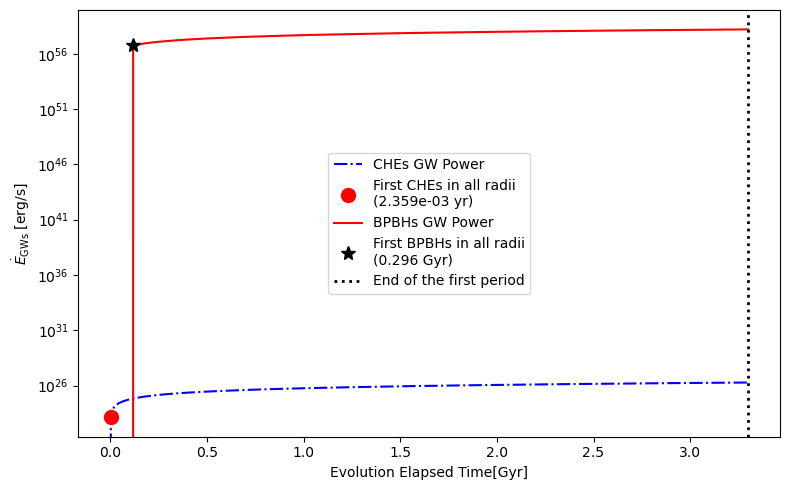

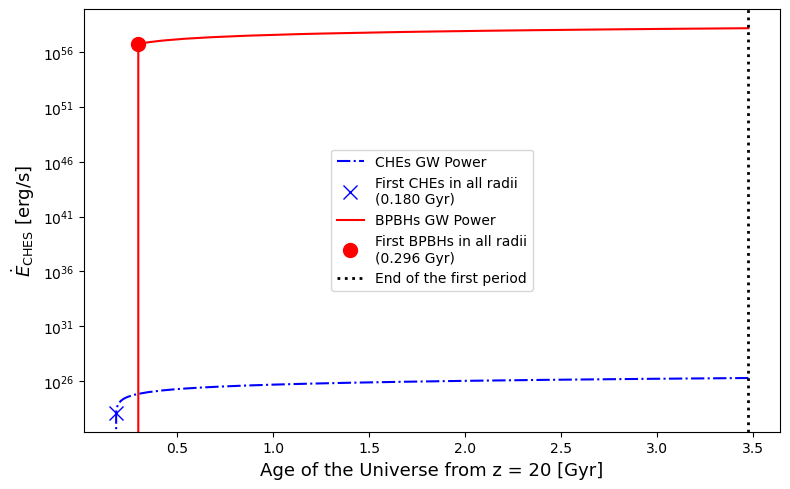

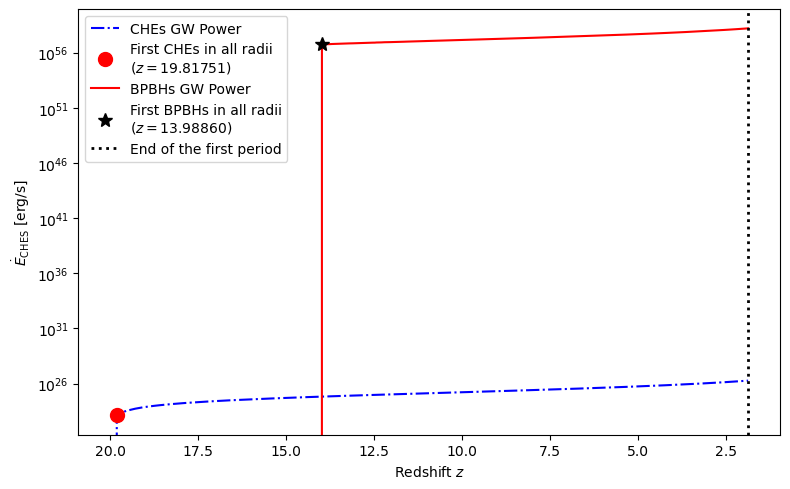

In [117]:
# Recupera los valores críticos
critical_time_yr = time_values_interval[idx_first_all]        # años
critical_time_gyr = critical_time_yr / 1e9                   # Gyr
critical_redshift = redshift_evaluated_0[idx_first_all]
critical_Edot = E_dot_CHES_0[idx_first_all]
critical_abs_age_gyr = (time_z_20 + time_values_interval[idx_first_all]) / 1e9

critical_merger_gyr = time_values_interval[first_bbh_idx]/1e9
critical_merger_redshift = redshift_evaluated_0[first_bbh_idx]
critical_merger_Edot = E_dot_BBH_0[first_bbh_idx]
critical_merger_age_gyr = (time_z_20 + time_values_interval[first_bbh_idx]) / 1e9

# --- vs tiempo evolution (en Gyr) ---
plt.figure(figsize=(8,5))
plt.plot(time_values_interval/1e9, E_dot_CHES_0, color='blue', linestyle = '-.', label='CHEs GW Power')
plt.plot(critical_time_gyr, critical_Edot, 'o', color='red', markersize=10, label=f'First CHEs in all radii\n({critical_time_yr/1e9:.3e} yr)')
plt.plot(time_values_interval/1e9, E_dot_BBH_0, color='red', label='BPBHs GW Power')
plt.plot(critical_merger_gyr, critical_merger_Edot, '*', color='black', markersize=10, label=f'First BPBHs in all radii\n({critical_merger_age_gyr:.3f} Gyr)')
plt.axvline(time_period_1_Gyr, color='black', linestyle=':', linewidth=2, label=f'End of the first period')
plt.xlabel('Evolution Elapsed Time[Gyr]')
plt.ylabel(r'$\dot{E}_{\mathrm{GWs}}$ [erg/s]')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.savefig('GW_power_vs_time_evolution.pdf')
plt.show()

# --- vs edad absoluta (en Gyr) ---
plt.figure(figsize=(8,5))
plt.plot((time_z_20+time_values_interval)/1e9, E_dot_CHES_0, color='blue', linestyle = '-.', label='CHEs GW Power')
#plt.axvline(critical_abs_age_gyr, color='red', ls='--', lw=2,
#            label=f'First CHEs in all radii\n({critical_abs_age_gyr:.3f} Gyr)')
plt.plot(critical_abs_age_gyr, critical_Edot, 'x', color='blue', markersize=10, label=f'First CHEs in all radii\n({critical_abs_age_gyr:.3f} Gyr)')
plt.plot((time_z_20+time_values_interval)/1e9, E_dot_BBH_0, color='red', label='BPBHs GW Power')
plt.plot(critical_merger_age_gyr, critical_merger_Edot, 'o', color='red', markersize=10, label=f'First BPBHs in all radii\n({critical_merger_age_gyr:.3f} Gyr)')
plt.axvline(((time_z_20+time_values_interval)/1e9)[-1], color='black', linestyle=':', linewidth=2, label=f'End of the first period')
plt.xlabel('Age of the Universe from z = 20 [Gyr]', fontsize=13)
plt.ylabel(r'$\dot{E}_{\mathrm{CHES}}$ [erg/s]', fontsize=13)
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.savefig('GW_power_vs_absolute_age.pdf')
plt.show()

# --- vs redshift ---
plt.figure(figsize=(8,5))
plt.plot(redshift_evaluated_0, E_dot_CHES_0, color='blue', linestyle = '-.',label='CHEs GW Power')
plt.plot(critical_redshift, critical_Edot, 'o', color='red', markersize=10, label=f'First CHEs in all radii\n($z={critical_redshift:.5f}$)')
plt.plot(redshift_evaluated_0, E_dot_BBH_0, color='red', label='BPBHs GW Power')
plt.plot(critical_merger_redshift, critical_merger_Edot, '*', color='black', markersize=10, label=f'First BPBHs in all radii\n($z={critical_merger_redshift:.5f}$)')
plt.axvline(redshift_evaluated_0[-1], color='black', linestyle=':', linewidth=2, label=f'End of the first period')
plt.xlabel('Redshift $z$')
plt.ylabel(r'$\dot{E}_{\mathrm{CHES}}$ [erg/s]')
plt.yscale('log')
plt.gca().invert_xaxis()
plt.legend()
plt.tight_layout()
plt.savefig('GW_power_vs_redshift.pdf')
plt.show()

# Second Generation

In [118]:
#N_PBH_1G = np.sum(N_BPBH_0G) #PBHs de primera generación obtenidos de la población original N_BPBH_0G desde el primer merger
N_PBH_1G = np.sum(N_BBH)#Entonces N_BBH es el array de BPBHs despues del primer periodo

M_PBH_1G = final_masses 
M_PBH_0G = M_PBH 
M_1G = N_PBH_1G * M_PBH_1G 
N_PBH_0G = n_total - (2*N_PBH_1G)
M_tot_0G = N_PBH_0G*M_PBH #masa total de los PBHs_0G que contribuyen a la masa total del cluster
M_DM_c_1G = M_tot_0G + M_1G #masa total del cluster para la 1G
M_LOST_GW = M_DM_cluster - M_DM_c_1G #cantidad de masa perdida por emisión de ondas gravitacionales de binarias
percent_lost_GW = (M_LOST_GW / M_DM_cluster) * 100

print(f"Number of PBHs of initial generation: {N_PBH_0G:.0f} of {M_PBH_0G:.2f} Solar Mass")
print(f"Number of PBHs of 1st generation:     {N_PBH_1G:.0f} of {M_PBH_1G:.2f} Solar Mass")
print(f"Cluster Mass after 1st generation:    {M_DM_c_1G:.4e} Solar Mass")
print(f"Mass lost by GWs (BPBH mergers):       {M_LOST_GW:.4f} Solar Mass")
print(f"Percentage of Cluster Mass Lost by GWs: {percent_lost_GW:.1f}%")

Number of PBHs of initial generation: 2868 of 10.00 Solar Mass
Number of PBHs of 1st generation:     3566 of 17.50 Solar Mass
Cluster Mass after 1st generation:    9.1085e+04 Solar Mass
Mass lost by GWs (BPBH mergers):       8914.9824 Solar Mass
Percentage of Cluster Mass Lost by GWs: 8.9%


In [ ]:
# ===================== INICIO BLOQUE CORREGIDO =====================

M_DM_cluster = M_DM_c_1G
N_0G = n_PBH_r - (2 * N_BBH)     # PBHs remanentes de 0G por cascarón (cuentas)
N_1G = N_BBH                     # PBHs 1G por cascarón (cuentas)

from itertools import combinations_with_replacement

# --- Definir las especies con sus arrays de número por cascarón ---
especies = [
    {"name": "0G", "N_array": N_0G, "M": M_PBH},
    {"name": "1G", "N_array": N_1G, "M": final_masses}
]

# --- Generar combinaciones con reemplazo: (0G–0G, 0G–1G, 1G–1G) ---
combinaciones_preparadas = []
for sp_i, sp_j in combinations_with_replacement(especies, 2):
    nombre_i, N_i_array, M_i = sp_i["name"], sp_i["N_array"], sp_i["M"]
    nombre_j, N_j_array, M_j = sp_j["name"], sp_j["N_array"], sp_j["M"]

    # Si son de la misma especie (0G–0G o 1G–1G), dividir a la mitad
    Ni_eff = np.round(N_i_array / 2) if nombre_i == nombre_j else N_i_array.copy()
    Nj_eff = np.round(N_j_array / 2) if nombre_i == nombre_j else N_j_array.copy()

    combinaciones_preparadas.append((nombre_i, nombre_j, Ni_eff, M_i, Nj_eff, M_j))


def evaluar_I_rj_por_combinacion(N_i, M_i, N_j, M_j, M_cluster):
    """
    Calcula I(r_j) para cada cascarón y devuelve sus coeficientes polinomiales.
    N_i y N_j son escalares (totales por especie, usados en v_rms).
    """
    I_values = np.array([
        I_rj(r_j, N_i, M_i, N_j, M_j, M_cluster)
        for r_j in r_values_pc
    ])
    coeffs = np.polyfit(r_values_pc, I_values, 3)
    return I_values, coeffs


# --- Gamma discreto por cascarón: BBH ---
def Gamma_rj_discreto_BBH(j, r_j, N_i_array, M_i, N_j_array, M_j, M_cluster, coeffs):
    """
    Devuelve Γ_BBH(r_j) por objeto [1/s] para la interacción (i-j) en el cascarón j.
    Calcula σ_BBH con velocidades locales (v_i, v_j) y factoriza correctamente el término de velocidad.
    """
    # Densidad numérica de la especie j en r_j (misma definición continua que usabas)
    n_j = n_pbh(r_j, M_j)  # [1/pc^3]
    if n_j <= 0:
        return 0.0

    # Velocidades RMS locales: seguimos la lógica global que ya usabas (depende del total por especie)
    N_i_tot = float(np.sum(N_i_array))
    N_j_tot = float(np.sum(N_j_array))

    v_i = mean_square_velocity(r_j, M_cluster, N_i_tot, M_i) * km_to_pc  # [pc/s]
    v_j = mean_square_velocity(r_j, M_cluster, N_j_tot, M_j) * km_to_pc  # [pc/s]

    if v_j <= 0:
        return 0.0

    # Sección eficaz con velocidades locales (la función espera km/s)
    sigma_B = sigma_BPBH(M_i, M_j, v_i / km_to_pc, v_j / km_to_pc)  # [pc^2] (tras tus factores internos)

    # I(r_j) por ajuste polinómico
    I_val = np.polyval(coeffs, r_j)

    # Factor de velocidad (coherente con tu Gamma_rj original)
    if np.isclose(v_i, v_j):
        vfac = (v_0_pc)**(18/7)
    else:
        vfac = (np.abs(v_i - v_j))**(18/7)

    gamma = vfac * (14.0 * np.pi / 3.0) * sigma_B * (n_j / v_j) * I_val  # [1/s]
    return float(gamma)


# --- Gamma discreto por cascarón: CHES ---
def Gamma_rj_discreto_CHES(j, r_j, N_i_array, M_i, N_j_array, M_j, M_cluster, coeffs):
    """
    Igual que la anterior pero usando σ_CHES con velocidades locales.
    """
    n_j = n_pbh(r_j, M_j)  # [1/pc^3]
    if n_j <= 0:
        return 0.0

    N_i_tot = float(np.sum(N_i_array))
    N_j_tot = float(np.sum(N_j_array))

    v_i = mean_square_velocity(r_j, M_cluster, N_i_tot, M_i) * km_to_pc  # [pc/s]
    v_j = mean_square_velocity(r_j, M_cluster, N_j_tot, M_j) * km_to_pc  # [pc/s]

    if v_j <= 0:
        return 0.0

    sigma_C = sigma_CHES(M_i, M_j, v_i / km_to_pc, v_j / km_to_pc)  # [pc^2]

    I_val = np.polyval(coeffs, r_j)

    if np.isclose(v_i, v_j):
        vfac = (v_0_pc)**(18/7)
    else:
        vfac = (np.abs(v_i - v_j))**(18/7)

    gamma = vfac * (14.0 * np.pi / 3.0) * sigma_C * (n_j / v_j) * I_val  # [1/s]
    return float(gamma)


# --- Evaluación por cada combinación de especies ---
resultados_discretos = []

E_dot_BBH_dict = {}
E_dot_CHES_dict = {}
M_dict = {}
N_coll_BPBH_dict = {}
N_coll_CHES_dict = {}

for nombre_i, nombre_j, N_i_array, M_i, N_j_array, M_j in combinaciones_preparadas:
    print(f"\nEvaluando interacción {nombre_i}-{nombre_j}...")

    # --- I(r_j) y coeficientes (usa totales por especie, coherente con tu esquema de v_rms) ---
    I_vals, coeffs_ij = evaluar_I_rj_por_combinacion(np.sum(N_i_array), M_i, np.sum(N_j_array), M_j, M_DM_cluster)

    # ----------------------
    # --- BBH CALCULATIONS --
    # ----------------------
    Gamma_values = np.array([
        Gamma_rj_discreto_BBH(j, r_values_pc[j], N_i_array, M_i, N_j_array, M_j, M_DM_cluster, coeffs_ij)
        for j in range(len(r_values_pc))
    ])
    Gamma_values_yr = Gamma_values * seconds_per_year
    mergers_total = Gamma_values_yr * age_universe_yr
    time_first_merger_yr = np.where(Gamma_values_yr > 0, 1.0 / Gamma_values_yr, np.inf)
    time_first_merger_Gyr = time_first_merger_yr / 1e9

    # Tiempo característico de evaluación (fijo, como pediste)
    delta_t_local = 2.3e9  # años
    time_period_2_yr = delta_t_local

    # Colisiones BBH (discretas por cascarón, a partir de probabilidad por objeto)
    Prob_form = Gamma_values_yr * delta_t_local
    N_coll_BBH = np.where(Prob_form * N_i_array > 0.9, np.round(Prob_form * N_i_array), 0.0)

    E_BBH_event = E_rad_GW(M_i, M_j, a0, a1)
    E_dot_BBH = N_coll_BBH * E_BBH_event  # erg en el intervalo delta_t_local (si quieres potencia, divide por delta_t_sec)

    M_result = final_mass_GW(M_i, M_j, a0, a1)
    M_dict[f"{nombre_i}-{nombre_j}"] = M_result

    # ------------------------
    # --- CHES CALCULATIONS --
    # ------------------------
    Gamma_CHES = np.array([
        Gamma_rj_discreto_CHES(j, r_values_pc[j], N_i_array, M_i, N_j_array, M_j, M_DM_cluster, coeffs_ij)
        for j in range(len(r_values_pc))
    ])
    Gamma_CHES_yr = Gamma_CHES * seconds_per_year
    Prob_emit = Gamma_CHES_yr * delta_t_local
    N_coll_CHES = np.round(Prob_emit * N_i_array)

    E_CHES_event = E_rad_CHES(M_i, M_j, e=1.01, K=1)
    E_dot_CHES = N_coll_CHES * E_CHES_event

    # ------------------------
    # --- Print Tab --
    # ------------------------
    print(f"Masses interacting")
    print(f"M_PBH_{nombre_i}: {M_i:.2f}")
    print(f"M_PBH_{nombre_j}: {M_j:.2f}")
    print(f"Mass_final_from_{nombre_i}-{nombre_j}: {M_dict[f'{nombre_i}-{nombre_j}']:.2f}")
    print(f"\n{'r_j (pc)':<10}{'Γ_BBH (yr^-1)':<15}{'Γ_CHES (yr^-1)':<17}"
          f"{'T_1st merge (Gyr)':<20}{'N_BBH':<10}{'N_CHES':<10}")
    print("=" * 80)
    for i in range(len(r_values_pc)):
        print(f"{r_values_pc[i]:<10.2f}"
              f"{Gamma_values_yr[i]:<15.3e}"
              f"{Gamma_CHES_yr[i]:<17.3e}"
              f"{time_first_merger_Gyr[i]:<20.3e}"
              f"{N_coll_BBH[i]:<10.1f}"
              f"{N_coll_CHES[i]:.1f}")

    # Discret_results
    N_coll_BPBH_dict[f"{nombre_i}-{nombre_j}"] = N_coll_BBH
    N_coll_CHES_dict[f"{nombre_i}-{nombre_j}"] = N_coll_CHES
    E_dot_BBH_dict[f"{nombre_i}-{nombre_j}"] = E_dot_BBH
    E_dot_CHES_dict[f"{nombre_i}-{nombre_j}"] = E_dot_CHES

    # ----------------------------
    # --- Summary 
    # ----------------------------
    print(f"\n[Resumen {nombre_i}-{nombre_j}]")
    print(f"Total BBH events = {int(np.sum(N_coll_BBH))}")
    print(f"Total CHES events = {int(np.sum(N_coll_CHES))}")
    print(f"P_BBH radiated (intervalo) = {np.sum(E_dot_BBH):.2e} erg")
    print(f"P_CHES radiated (intervalo) = {np.sum(E_dot_CHES):.2e} erg")

    # --- Save Results ---
    resultados_discretos.append({
        "interaccion": f"{nombre_i}-{nombre_j}",
        "Gamma_values_yr": Gamma_values_yr,
        "Mass_final": M_result,
        "N_collisions_BBH": N_coll_BBH,
        "N_collisions_CHES": N_coll_CHES,
        "E_event_BBH": E_BBH_event,
        "E_event_CHES": E_CHES_event,
        "E_dot_BBH": E_dot_BBH,
        "E_dot_CHES": E_dot_CHES,
        "sigma_BBH": None,     # ahora σ se calcula por cascarón
        "sigma_CHES": None
    })



In [ ]:
# ===================== A PARTIR DE AQUÍ: BLOQUE NUEVO =====================






print("delta_t_merger (yr) ≈", delta_t_merger)
print("time necesary to first merger from Z = 20: ", delta_t_merger/1e9,"Gyr")

if not np.isfinite(delta_t_CHEs):
    delta_t_CHEs = 1.0e7  # fallback (10 Myr) si no hay tasas finitas
print("time necesary to first CHEs from Z = 20: ",delta_t_CHEs,"years")



# --- Parámetros de separación inicial y final ---
a0 = (2 * G_SI * M_PBH * Msun_kg) / c_SI**2 / pc_m   # pc
a1 = 0.1 * AU_pc                                     # pc

# --- Energía radiada BBH ---
def E_rad_GW(m1, m2, a0, a1):
    m1_kg = m1 * Msun_kg
    m2_kg = m2 * Msun_kg
    def integrand(a_pc):
        a_m = a_pc * pc_m
        return (G_SI * m1_kg * m2_kg) / (2 * a_m**2) * pc_m  # J
    integral, _ = spi.quad(integrand, a0, a1)
    return integral / erg_in_joule  # erg

# --- Masa final tras fusión BBH ---
def final_mass_GW(m1, m2, a0, a1):
    E_rad = E_rad_GW(m1, m2, a0, a1) * erg_in_joule  # J
    m_total = (m1 + m2) * Msun_kg
    m_final = m_total - E_rad / c_SI**2
    return m_final / Msun_kg  # M_sun

# --- Radio mínimo para CHES (en parsecs) ---
def r_min_CHES(m1, m2, K = 0.01):
    m1_kg = m1 * Msun_kg
    m2_kg = m2 * Msun_kg
    R_sch = lambda m: 2 * G_SI * m / c_SI**2  # m
    return K * (R_sch(m1_kg) + R_sch(m2_kg)) / pc_m  # pc

# --- Energía radiada CHES ---
def E_rad_CHES(m1, m2, e=1.01, K=0.01):
    m1_kg = m1 * Msun_kg
    m2_kg = m2 * Msun_kg
    M = m1_kg + m2_kg
    r_min_m = r_min_CHES(m1, m2, K) * pc_m  # m
    # f(e) factor (Eq. 18)
    term1 = 24 * np.arccos(-1 / e) * (1 + (73/24)*e**2 + (37/96)*e**4)
    term2 = np.sqrt(e**2 - 1) * (301/6 + (673/12)*e**2)
    f_e = (1 / (1 + e)**(7/2)) * (term1 + term2)
    E_rad = (8/15) * G_SI**(3.5) * np.sqrt(M) * m1_kg**2 * m2_kg**2 / (c_SI**5 * r_min_m**(3.5)) * f_e
    return E_rad / erg_in_joule  # erg

# --- Evaluación de energías y masa final ---
E_BBH_event = E_rad_GW(M_PBH, M_PBH, a0, a1)             # erg
E_CHES_event = E_rad_CHES(M_PBH, M_PBH)                  # erg
final_masses = final_mass_GW(M_PBH, M_PBH, a0, a1)       # M_sun

# Grilla de tiempos
time_values_interval_0 = np.linspace(1e3, delta_t_CHEs, 300) #Years
time_values_interval_0 = np.insert(time_values_interval_0, 0, 0.0)
time_values_interval_1 = np.linspace(delta_t_CHEs, 3.3e+09, 500) #Years
time_values_interval = np.concatenate((time_values_interval_0, time_values_interval_1[1:]))

t_yr=[]
redshift_evaluated_0 = []
for t in time_values_interval:
    t_yr.append(t + time_z_20)
    t_gyr = (t + time_z_20) / 1e9  # Gyr
    z = z_at_value(cosmo.age, t_gyr * u.Gyr, zmax=25).value
    redshift_evaluated_0.append(z)

time_period_1_yr = time_values_interval[799] #yr
time_period_1_Gyr = time_values_interval[799]/1e9 #Gyr
time_period_seconds = ((time_period_1_yr * u.yr).to(u.s)).value
print(time_period_1_Gyr, time_period_seconds, redshift_evaluated_0[799])

# Si no los tienes, inicialízalos antes del bucle:
N_CHES_0 = np.zeros_like(time_values_interval)
E_dot_CHES_0 = np.zeros_like(time_values_interval)
N_BBH_0 = np.zeros_like(time_values_interval)
E_dot_BBH_0 = np.zeros_like(time_values_interval)
BPBH_ALL_PERIOD = []
idx_first_all = None
first_bbh_idx = None
Probabilidad_total = np.zeros_like(time_values_interval)
Probabilidad_total_bbh = np.zeros_like(time_values_interval)

for i, t in enumerate(time_values_interval):
    # CHEs
    Prob_CHES_emit = Gamma_CHES_values_yr * t
    Proptot = np.sum(Prob_CHES_emit)
    Probabilidad_total[i] = Proptot
    #print("--> elapsep time(yr):",t)
    #print("Prob_CHES_r:",Prob_CHES_emit, "Proptot =", Proptot)
    N_CHES = np.round(Prob_CHES_emit * (n_PBH_r / 2))
    #print(N_CHES)
    if np.any(N_CHES == 0):
        N_CHES = np.zeros_like(Prob_CHES_emit)
    #print(N_CHES)
    if np.all(N_CHES > 0) and idx_first_all is None:
        idx_first_all = i
        print("Time necesary to obtain 1 CHEs in all radius of the Cluster:", t, "years")
        print("Time necesary to obtain 1 CHEs in all radius of the Cluster:", t/1e9, "Gyr")
        print("Redshift:", z_at_value(cosmo.age, ((t + time_z_20) / 1e9) * u.Gyr, zmax=25).value)
    N_CHES_tot = np.sum(N_CHES)
    N_CHES_0[i] = N_CHES_tot
    if t==0.:
        E_dot_CHES_shell = 0.
    else:
        E_dot_CHES_shell = (N_CHES_tot * E_CHES_event)
    #print(N_CHES_tot, E_dot_CHES_shell)
    E_dot_CHES_shell_tot = np.sum(E_dot_CHES_shell)
    E_dot_CHES_0[i] = E_dot_CHES_shell_tot

    # BBH
    Prob_BPBH_form = Gamma_values_yr * t
    Proptot_bbh = np.sum(Prob_BPBH_form)
    Probabilidad_total_bbh[i] = Proptot_bbh
    #print("Prob_BBH_r:",Prob_BPBH_form, "Proptot_form_bbh =", Proptot_bbh)
    N_BBH = np.where(Prob_BPBH_form * (n_PBH_r/2) > 0.9, np.round(Prob_BPBH_form * (n_PBH_r)), 0.0)
    if np.any(N_BBH == 0):
        N_BBH = np.zeros_like(Prob_BPBH_form)
    N_BBH_tot = np.sum(N_BBH)
    if first_bbh_idx is None and N_BBH_tot > 0:
        first_bbh_idx = i
        print(f"Time necesary to obtain mergers in all radius of the Cluster: {t} years")
        print(f"Time necesary to obtain mergers in all radius of the Cluster: {t/1e9} Gyr")
        print("Redshift:", z_at_value(cosmo.age, ((t + time_z_20) / 1e9) * u.Gyr, zmax=25).value)
        print(N_BBH)
        N_BPBH_0G = N_BBH
        print(N_BBH_tot)
    #print("Binary in every r:", N_BBH)
    N_BBH_0[i] = N_BBH_tot
    E_dot_BBH_shell = (N_BBH * E_BBH_event)
    E_dot_BBH_shell_tot = np.sum(E_dot_BBH_shell)
    E_dot_BBH_0[i] = E_dot_BBH_shell_tot

print("\nIf we consider a especific time to evaluated we have:")
print(N_BBH, "Total number of PBHs of the first period", N_BBH_tot)
print(t/1e9, "Gyr")
BPBH_ALL_PERIOD.append(N_BBH_tot) #Before a total time to evaluated

POPULATION_BPBH_BY_GENERATION = [N_BBH_tot]
EMISSION_GW_OF_BPBH = [E_dot_BBH_shell_tot]
NUMBER_OF_CHES_BY_GENERATION = [N_CHES_tot]
EMISSION_GW_OF_CHES = [E_dot_CHES_shell_tot]
PERIOD_OF_EVOLUTION_GYR = [time_period_1_Gyr]
Z_PERIOD = [redshift_evaluated_0[-1]]

print(N_BBH, "Total number of PBHs of the first period", N_BBH_tot, E_dot_BBH_shell_tot)
print(N_CHES, N_CHES_tot, E_dot_CHES_shell_tot)
print(time_period_1_Gyr, time_period_seconds)
print(redshift_evaluated_0[-1])

# Recupera los valores críticos con guardas
if idx_first_all is not None:
    critical_time_yr = time_values_interval[idx_first_all]        # años
    critical_time_gyr = critical_time_yr / 1e9                   # Gyr
    critical_redshift = redshift_evaluated_0[idx_first_all]
    critical_Edot = E_dot_CHES_0[idx_first_all]
    critical_abs_age_gyr = (time_z_20 + time_values_interval[idx_first_all]) / 1e9
else:
    critical_time_yr = critical_time_gyr = critical_redshift = critical_Edot = critical_abs_age_gyr = np.nan

if first_bbh_idx is not None:
    critical_merger_gyr = time_values_interval[first_bbh_idx]/1e9
    critical_merger_redshift = redshift_evaluated_0[first_bbh_idx]
    critical_merger_Edot = E_dot_BBH_0[first_bbh_idx]
    critical_merger_age_gyr = (time_z_20 + time_values_interval[first_bbh_idx]) / 1e9
else:
    critical_merger_gyr = critical_merger_redshift = critical_merger_Edot = critical_merger_age_gyr = np.nan

# --- vs tiempo evolution (en Gyr) ---
plt.figure(figsize=(8,5))
plt.plot(time_values_interval/1e9, E_dot_CHES_0/time_period_seconds, color='blue', linestyle = '-.', label='CHEs GW Power')
if np.isfinite(critical_time_gyr):
    plt.plot(critical_time_gyr, critical_Edot/time_period_seconds, 'o', color='red', markersize=10, label=f'First CHEs in all radii\n({critical_time_yr/1e9:.3e} yr)')
plt.plot(time_values_interval/1e9, E_dot_BBH_0/time_period_seconds, color='red', label='BPBHs GW Power')
if np.isfinite(critical_merger_gyr):
    plt.plot(critical_merger_gyr, critical_merger_Edot/time_period_seconds, '*', color='black', markersize=10, label=f'First BPBHs in all radii\n({critical_merger_age_gyr:.3f} Gyr)')
plt.axvline(time_period_1_Gyr, color='black', linestyle=':', linewidth=2, label=f'End of the first period')
plt.xlabel('Evolution Elapsed Time[Gyr]')
plt.ylabel(r'$\dot{E}_{\mathrm{GWs}}$ [erg/s]')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.savefig('GW_power_vs_time_evolution.pdf')
plt.show()

# --- vs edad absoluta (en Gyr) ---
plt.figure(figsize=(8,5))
plt.plot((time_z_20+time_values_interval)/1e9, E_dot_CHES_0/time_period_seconds, color='blue', linestyle = '-.', label='CHEs GW Power')
if np.isfinite(critical_abs_age_gyr):
    plt.plot(critical_abs_age_gyr, critical_Edot/time_period_seconds, 'x', color='blue', markersize=10, label=f'First CHEs in all radii\n({critical_abs_age_gyr:.3f} Gyr)')
plt.plot((time_z_20+time_values_interval)/1e9, E_dot_BBH_0/time_period_seconds, color='red', label='BPBHs GW Power')
if np.isfinite(critical_merger_age_gyr):
    plt.plot(critical_merger_age_gyr, critical_merger_Edot/time_period_seconds, 'o', color='red', markersize=10, label=f'First BPBHs in all radii\n({critical_merger_age_gyr:.3f} Gyr)')
plt.axvline(((time_z_20+time_values_interval)/1e9)[-1], color='black', linestyle=':', linewidth=2, label=f'End of the first period')
plt.xlabel('Age of the Universe from z = 20 [Gyr]', fontsize=13)
plt.ylabel(r'$\dot{E}_{\mathrm{CHES}}$ [erg/s]', fontsize=13)
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.savefig('GW_power_vs_absolute_age.pdf')
plt.show()

# --- vs redshift ---
plt.figure(figsize=(8,5))
plt.plot(redshift_evaluated_0, E_dot_CHES_0/time_period_seconds, color='blue', linestyle = '-.',label='CHEs GW Power')
if np.isfinite(critical_redshift):
    plt.plot(critical_redshift, critical_Edot/time_period_seconds, 'o', color='red', markersize=10, label=f'First CHEs in all radii\n($z={critical_redshift:.5f}$)')
plt.plot(redshift_evaluated_0, E_dot_BBH_0/time_period_seconds, color='red', label='BPBHs GW Power')
if np.isfinite(critical_merger_redshift):
    plt.plot(critical_merger_redshift, critical_merger_Edot/time_period_seconds, '*', color='black', markersize=10, label=f'First BPBHs in all radii\n($z={critical_merger_redshift:.5f}$)')
plt.axvline(redshift_evaluated_0[-1], color='black', linestyle=':', linewidth=2, label=f'End of the first period')
plt.xlabel('Redshift $z$')
plt.ylabel(r'$\dot{E}_{\mathrm{CHES}}$ [erg/s]')
plt.yscale('log')
plt.gca().invert_xaxis()
plt.legend()
plt.tight_layout()
plt.savefig('GW_power_vs_redshift.pdf')
plt.show()

fig, ax1 = plt.subplots(figsize=(8, 5))
ax1.plot(redshift_evaluated_0, E_dot_CHES_0/time_period_seconds, color='navy', label=r'$\dot{E}_{\mathrm{CHES}}$')
if np.isfinite(critical_redshift):
    ax1.plot(critical_redshift, critical_Edot/time_period_seconds, 'o', color='red', markersize=10, label=f'Redshift to CHEs in all radii\n($z={critical_redshift:.5f}$)')
ax1.set_xlabel('Redshift $z$')
ax1.set_ylabel(r'$\dot{E}_{\mathrm{CHES}}$ [erg/s]')
ax1.set_yscale('log')
ax1.set_title('Total CHEs Power vs Redshift and CHEs Count')
ax1.invert_xaxis()
ax1.legend()

# Eje x superior: N_CHES_0
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())

def tick_function(ticks, redshifts, N_CHES_0):
    ticks_clipped = np.clip(ticks, min(redshifts), max(redshifts))
    return ["%d" % int(np.interp(t, redshifts[::-1], N_CHES_0[::-1])) for t in ticks_clipped]

tick_locs = ax1.get_xticks()
valid_ticks = [t for t in tick_locs if min(redshift_evaluated_0) <= t <= max(redshift_evaluated_0)]
ax2.set_xticks(valid_ticks)
ax2.set_xticklabels(tick_function(valid_ticks, redshift_evaluated_0, N_CHES_0))
ax2.set_xlabel('Cumulative CHEs Count $N_{\mathrm{CHES}}$')
plt.tight_layout()
plt.savefig('GW_power_vs_redshift_CHEs_count.pdf')
plt.show()

fig, ax1 = plt.subplots(figsize=(8, 5))
ax1.plot(redshift_evaluated_0, E_dot_BBH_0/time_period_seconds, color='navy', label=r'$\dot{E}_{\mathrm{BPBH}}$')
if np.isfinite(critical_merger_redshift):
    ax1.plot(critical_merger_redshift, critical_merger_Edot/time_period_seconds, '*', color='red', markersize=10, label=f'Redshift to obtain BPBHs in all radii\n($z={critical_merger_redshift:.5f}$)')
ax1.set_xlabel('Redshift $z$')
ax1.set_ylabel(r'$\dot{E}_{\mathrm{BPBH}}$ [erg/s]')
ax1.set_yscale('log')
ax1.set_title('Total BPBHs Power vs Redshift and BPBHs Count')
ax1.invert_xaxis()
ax1.legend()

# Eje x superior: N_BPBH_0
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())

def tick_function_bbh(ticks, redshifts, N_bpbh):
    ticks_clipped = np.clip(ticks, min(redshifts), max(redshifts))
    return ["%d" % int(np.interp(t, redshifts[::-1], N_bpbh[::-1])) for t in ticks_clipped]

tick_locs = ax1.get_xticks()
valid_ticks = [t for t in tick_locs if min(redshift_evaluated_0) <= t <= max(redshift_evaluated_0)]
ax2.set_xticks(valid_ticks)
ax2.set_xticklabels(tick_function_bbh(valid_ticks, redshift_evaluated_0, N_BBH_0))
ax2.set_xlabel('Cumulative BPBHs Count $N_{\mathrm{BPBHs}}$')
plt.tight_layout()
plt.savefig('GW_power_vs_redshift_BPBHs_count.pdf')
plt.show()